# Visualization Tool Overview

<img src="Interface.png" style="width: 1000px;"/>

* Select a range date and click on "Update Data" (1) to visualize data obtained trought the NYC311. Click on the layer button (8) to visualize complaints of different categories. Hover on the stream graph (4) to display the number of complaints of an specific category occurred in a specific time.
* Load the inference result files (2) to plot the inferred noise over the map. Colors will represent the number of complaints (9).
* Change the time range (3) to see how the inferred noise varies during different hours of the day.
* Hover on a region (5) to show its general information (6) as the inferred complaints (7) -- discretized by categories -- that occurred in the selected time range (3). A bar plot displaying the number complaints discretized by categories and hours of the day will also be shown.


# Current Results

# 1. Features

* Date range: 2015-01-01 / 2015-12-31
* 53147 POIs
* Road bed with 367082 nodes and 96325 edges
* 141912645 taxi trips
* 896 complaints (311)

### 311 Complaints Heat Map

<img src="311Data.png" style="width: 800px;"/>


# 2. Loading Data

In [3]:
%matplotlib inline

import numpy
import matplotlib
import matplotlib.pyplot as plt

B = numpy.loadtxt("../Results/B.csv", delimiter=",")  # 149 x 4
C = numpy.loadtxt("../Results/C.csv", delimiter=",")  # 18 x 18
D = numpy.loadtxt("../Results/D.csv", delimiter=",")  # 149 x 24

# 3. Analyzing Complaints' Categories Correlation Matrix

In [4]:
categories = ['Air Condition/Ventilation Equipment', 
              'Alarms',
              'Banging/Pounding', 
              'Barking Dog', 
              'Car/Truck Horn',
              'Car/Truck Music', 
              'Construction Equipment',
              'Construction Before/After Hours', 
              'Engine Idling',
              'Ice Cream Truck', 
              'Jack Hammering', 
              'Lawn Care Equipment',
              'Loud Music/Party', 
              'Loud Talking', 
              'Loud Television',
              'Manufacturing Noise', 
              'Others',
              'Private Carting Noise']

max_corr = numpy.argmax(C)
min_corr = numpy.argmin(C)

print 'dim(C)', numpy.shape(C)  # checking
print 'Max correlation =', numpy.max(C), 'for categories', categories[max_corr/18], '|', categories[max_corr%18]
print 'Min correlation =', numpy.min(C), 'for categories', categories[min_corr/18], '|', categories[min_corr%18]

dim(C) (18, 18)
Max correlation = 1.0 for categories Air Condition/Ventilation Equipment | Air Condition/Ventilation Equipment
Min correlation = 0.0 for categories Air Condition/Ventilation Equipment | Alarms


For a 311 complaint $ns$ (of the $i$th category), we count the complaints of other categories $varphi_j$ ($i \leq j \leq M, j \neq i$) within the distance $\delta$ to $n$. 
Then the correlation between two categories $c_i$ and $c_j$ can be calculated as:    

$$cor(c_i, c_j) = \dfrac{\sum_{ns \in \Psi, ns.c=c_i \mid \varphi_j \mid}}{\mid c_i \mid \dot \mid c_j \mid}$$ with $c_i \neq c_j$.

$$\varphi_j = {ns' \mid dist(ns.l, ns'.l) \leq \delta \wedge ns'.c = c_j}$$

Where $\mid c_i \mid$ and $\mid c_j \mid$ denote the number of  complaints in category $c_i$ and $c_j$ respectively, $\Psi$ is the collection of 311 data.

In [5]:
def fillCorr(complaints_loc, dist):
    """
    Fill the correlation matrix for the Tensor Context Aware Decomposition.
    :param complaints_loc: dictionary {complaint type : [coordinates]}
    :param dist: minimum distance between coordinates to be considered.
    :return: numpy array containing the correlation between each complaint category.
    """
    complaints_loc = collections.OrderedDict(sorted(complaints_loc.items()))  # To maintain an order in a dict
    categories = len(complaints_loc)                                          # Number of different categories

    Z = numpy.ones((categories, categories))

    for index_1, key_1 in enumerate(complaints_loc):
        for index_2, key_2 in enumerate(complaints_loc):  # Forming pairs
            if index_1 != index_2:
                loc_1 = complaints_loc[key_1]  # List of tuples corresponding to coordinates for type *i*
                loc_2 = complaints_loc[key_2]  # List of tuples corresponding to coordinates for type *j*
                sum = 0
                for l1 in loc_1:
                    for l2 in loc_2:
                        p1 = (l1[0], l1[1])
                        p2 = (l2[0], l2[1])
                        if haversine(p1, p2) <= dist:  # Distance between two complaints of types *i* and *j*
                            sum += 1
                mul = float(len(loc_1) * len(loc_2))
                if mul != 0:
                    Z[index_1, index_2] = sum / mul    # Correlation between category *i* and *j*
                else:
                    Z[index_1, index_2] = 0.0

    return Z

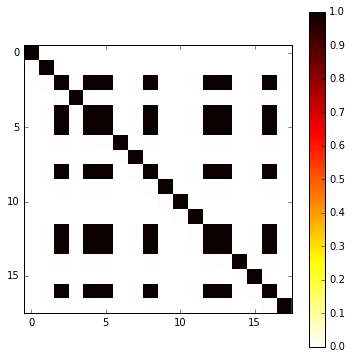

In [6]:
plt.figure(figsize=(6, 6), dpi=200)
fig = plt.imshow(C, cmap=plt.cm.hot_r, interpolation='none')
plt.axes().set_aspect('equal')
plt.colorbar(fig)

Easy to see that the correlation matrix is not good... The distance used was 100. All correlations that are non-zero are 1.0. Changing the distance parameter changed slightly the correlation value, but not the instances that have correlations between each other.

In [7]:
for i in range(0, 15):
    for j in range(i, 15):
        if i!=j and C[i, j] != 0.0:
            print C[i, j], ':', i, j, '-', categories[i%18], '|', categories[j%18]

1.0 : 2 4 - Banging/Pounding | Car/Truck Horn
1.0 : 2 5 - Banging/Pounding | Car/Truck Music
1.0 : 2 8 - Banging/Pounding | Engine Idling
1.0 : 2 12 - Banging/Pounding | Loud Music/Party
1.0 : 2 13 - Banging/Pounding | Loud Talking
1.0 : 4 5 - Car/Truck Horn | Car/Truck Music
1.0 : 4 8 - Car/Truck Horn | Engine Idling
1.0 : 4 12 - Car/Truck Horn | Loud Music/Party
1.0 : 4 13 - Car/Truck Horn | Loud Talking
1.0 : 5 8 - Car/Truck Music | Engine Idling
1.0 : 5 12 - Car/Truck Music | Loud Music/Party
1.0 : 5 13 - Car/Truck Music | Loud Talking
1.0 : 8 12 - Engine Idling | Loud Music/Party
1.0 : 8 13 - Engine Idling | Loud Talking
1.0 : 12 13 - Loud Music/Party | Loud Talking


Now let's check the top significant complaints in the input data (matrix A).

In [10]:
A = numpy.zeros((149, 18, 24))  # 149 x 18 x 24 -- original / sparse
P = numpy.zeros((149, 18, 24))  # 149 x 18 x 24 -- missing values inferred
for t in range(24):
    A[:, :, t] = numpy.loadtxt("../Results/A-"+str(t)+".csv", delimiter=",")
    P[:, :, t] = numpy.loadtxt("../Results/P-"+str(t)+".csv", delimiter=",")   
total_A = numpy.sum(A, axis=(0,2))
total_P = numpy.sum(P, axis=(0,2)) 

print 'dim(total_A)', total_A.shape
print 'dim(total_P)', total_P.shape

top_A = numpy.argpartition(total_A, -8, axis=None)[-8:]
top_P = numpy.argpartition(total_P, -8, axis=None)[-8:]

print 'Top 8 categories for input matrix A:'
sorted([(categories[i], numpy.round(total_A[i])) for i in top_A], key=lambda tup: tup[1])

dim(total_A) (18,)
dim(total_P) (18,)
Top 8 categories for input matrix A:


[('Construction Before/After Hours', 0.0),
 ('Car/Truck Horn', 13.0),
 ('Banging/Pounding', 22.0),
 ('Engine Idling', 24.0),
 ('Car/Truck Music', 55.0),
 ('Loud Talking', 120.0),
 ('Others', 273.0),
 ('Loud Music/Party', 389.0)]

In [11]:
print 'Top 8 categories for output matrix P:'
sorted([(categories[i], numpy.round(total_P[i])) for i in top_P], key=lambda tup: tup[1])

Top 8 categories for output matrix P:


[('Jack Hammering', 357.0),
 ('Car/Truck Music', 366.0),
 ('Construction Equipment', 368.0),
 ('Air Condition/Ventilation Equipment', 371.0),
 ('Ice Cream Truck', 402.0),
 ('Loud Talking', 431.0),
 ('Loud Music/Party', 920.0),
 ('Others', 1071.0)]

As we can see, there are three categories in commom between the input and output matrix (I'm not taking "Others" into account).

# 4. Analyzing Humam Mobility Features Matrix

In [13]:
print 'dim(D)', numpy.shape(D)  # checking
total_dropoffs = numpy.sum(D, axis=1)
print 'dim(total_dropofss)', numpy.shape(total_dropoffs)
top_dropoffs = numpy.argpartition(total_dropoffs, -10, axis=None)[-10:]
print 'Regions with most dropoffs:'
[(i, round(total_dropoffs[i], 2)) for i in top_dropoffs]

dim(D) (149, 24)
dim(total_dropofss) (149,)
Regions with most dropoffs:


[(10, 1.75),
 (130, 1.77),
 (0, 3.54),
 (139, 3.82),
 (121, 6.2),
 (105, 15.82),
 (104, 7.3),
 (8, 9.82),
 (4, 7.19),
 (97, 6.03)]

<img src="Dropoff.png" style="width: 800px;"/>

As can be seen, regions with highest number of dropoffs correspond to touristic regions of Manhattan. For example, such regions contains the One World Trade Center, Times Square, Washington Square, Flatiron Building, Empire State...

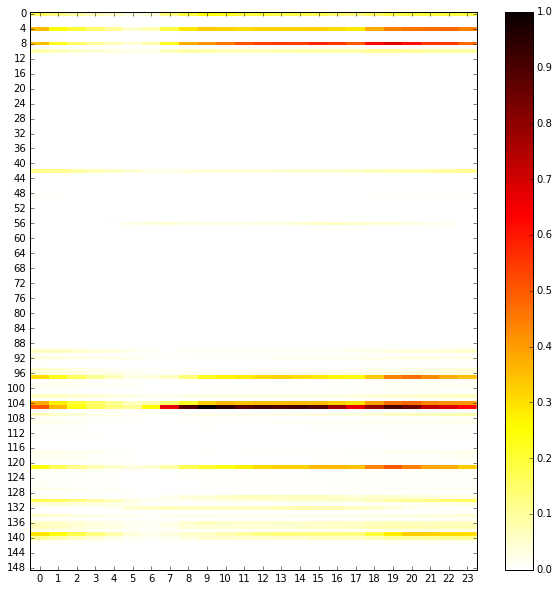

In [14]:
plt.figure(figsize=(10, 10), dpi=200)
fig = plt.imshow(D, cmap=plt.cm.hot_r, interpolation='none', aspect='auto')
plt.yticks(numpy.arange(0, 150, 4))
plt.xticks(numpy.arange(0, 24, 1))
plt.colorbar(fig)

Analyzing this image we can see that the majority of dropoffs in the highlighted areas occurs after 3pm. Regions 104 and 8, on the other hand, present most of its dropoffs between 6am and 17pm. 

## 5. Analyzing Regions' Features Matrix

In [15]:
print 'dim(B)', numpy.shape(B)  # checking

dim(B) (149, 4)


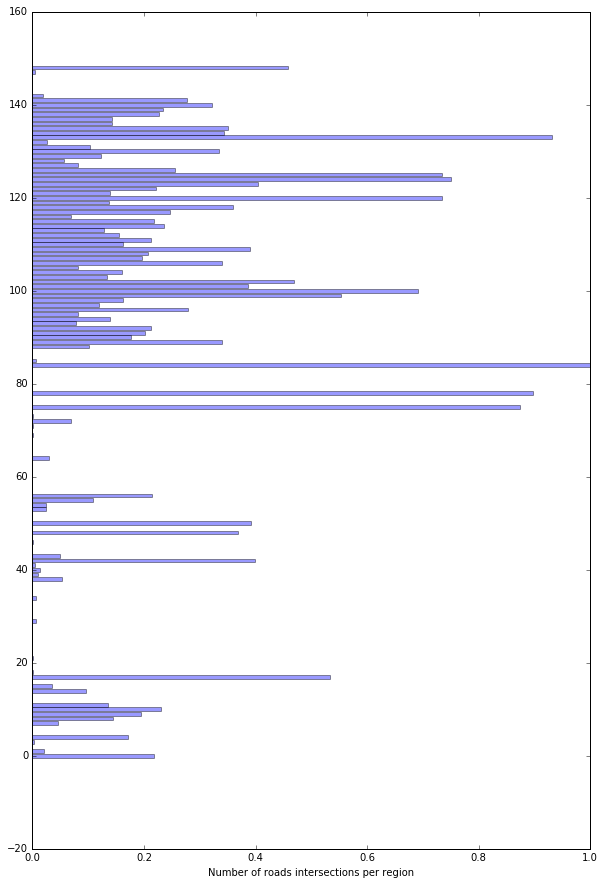

In [17]:
y_pos = numpy.arange(149)

plt.figure(figsize=(10, 15), dpi=200)
plt.barh(y_pos, B[:,0], align='center', alpha=0.4)
plt.xlabel('Number of roads intersections per region')

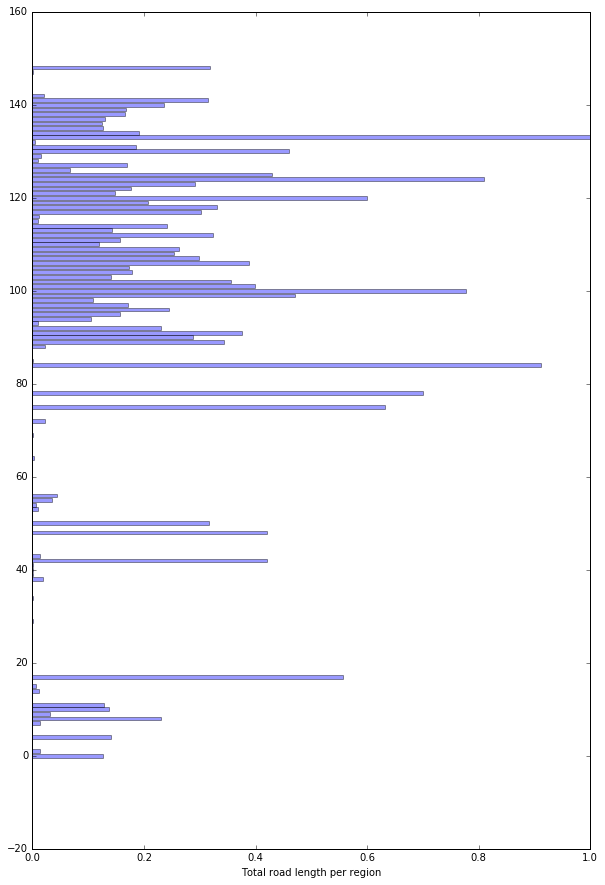

In [18]:
plt.figure(figsize=(10, 15), dpi=200)
plt.barh(y_pos, B[:,1], align='center', alpha=0.4)
plt.xlabel('Total road length per region')

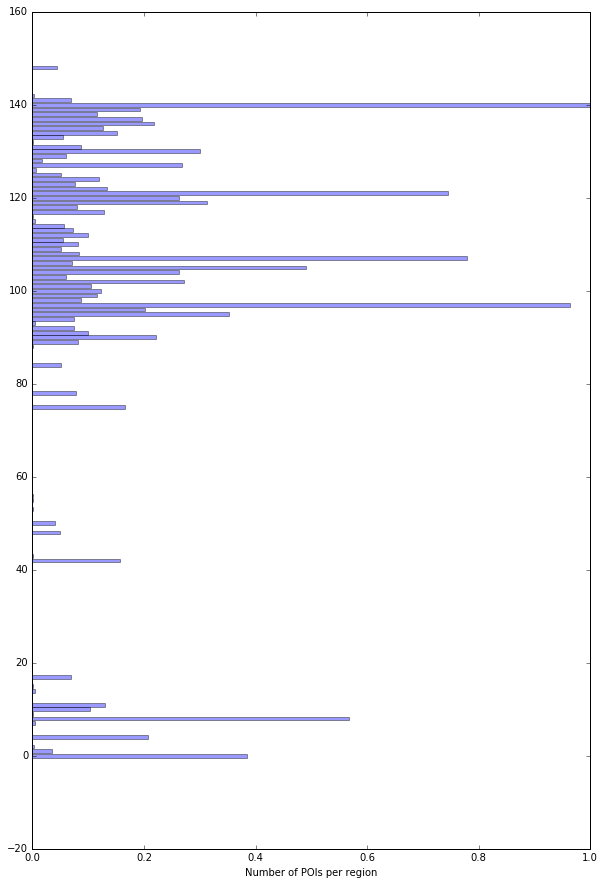

In [19]:
plt.figure(figsize=(10, 15), dpi=200)
plt.barh(y_pos, B[:,2], align='center', alpha=0.4)
plt.xlabel('Number of POIs per region')

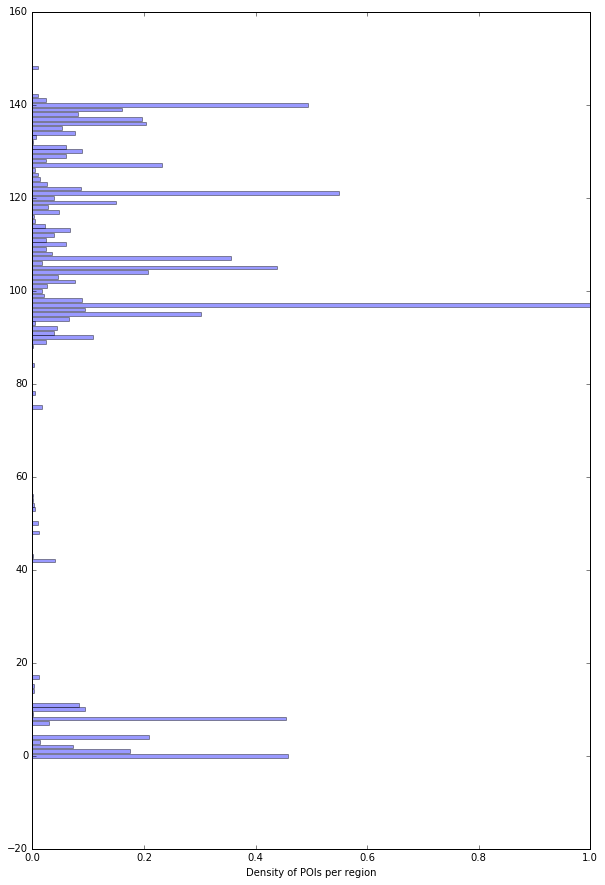

In [20]:
plt.figure(figsize=(10, 15), dpi=200)
plt.barh(y_pos, B[:,3], align='center', alpha=0.4)
plt.xlabel('Density of POIs per region')

# Considerations

* Comparing the 311 noise complaints map and the inferred noise complaints map, it's possible to see that some regions that were hightly noisy in the input were not among the top noisy regions in the output. For example, the regions that contains the Brooklyn Bridge Park.
* Not using POIs and/or Road data did not affect significantly the results (results were similar to the one obtained using all available data).
* Not using the human mobility feature also did not change the result signifincantly. 
* Conclusion: I'm having trouble to figure it out how each data affects the model.

# Future Work

* Figure it out a way to measure the quality of the current method.
* Propose a new method (maybe using Lasso) that includes the data available from Pluto (building features).
* Compare both methods.
* Instead of 'simply' infer the missing values, propose a method capable of some sort of prediction.